In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from IPython.display import display

from collections import defaultdict

In [2]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)
    

def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

# Data Preparation

In [3]:
df = pd.read_csv('/Users/samuele/University/2.DM2/fma_metadata/echo_popelec.csv')
df.set_index('track_id', inplace=True)
display(df.head())
display(df['genre_top'].value_counts())

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,genre_top
track_id,,,,,,,,,,,
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.963590,111.562,161,192,Pop
213,0.933741,0.312720,0.340999,0.919242,0.082976,0.032745,0.043054,142.499,247,256,Pop
384,0.444822,0.561166,0.700912,0.817286,0.111111,0.036441,0.344763,91.077,249,256,Electronic
386,0.436375,0.585549,0.782927,0.894428,0.142187,0.047893,0.301543,130.464,357,256,Electronic
387,0.464508,0.493599,0.552749,0.736318,0.110117,0.055116,0.221480,136.255,326,256,Electronic


Electronic    2049
Pop            337
Name: genre_top, dtype: int64

# Data Partitioning

In [6]:
attributes = [col for col in df.columns if col != 'genre_top']

X = df[attributes]
y = df['genre_top']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [7]:
# encoding labels
le = preprocessing.LabelEncoder()
y_test_enc = ~le.fit_transform(y_test).astype('bool')

In [9]:
df['genre_top'].value_counts()

Electronic    2049
Pop            337
Name: genre_top, dtype: int64

# RIPPER
## Pop - Electronic classifier

https://github.com/imoscovitz/wittgenstein

In [10]:
import wittgenstein as lw

In [16]:
for pr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
        clf = lw.RIPPER(random_state=42, prune_size=pr)
        clf.fit(X_train, y_train, class_feat='genre_top', pos_class='Electronic')
        y_predicted = clf.predict(X_test)
        print("prune_size: ", pr)
        print(classification_report(y_test_enc, y_predicted))

prune_size:  0.1
              precision    recall  f1-score   support

       False       0.31      0.55      0.39       100
        True       0.92      0.80      0.85       616

    accuracy                           0.76       716
   macro avg       0.61      0.67      0.62       716
weighted avg       0.83      0.76      0.79       716

prune_size:  0.2
              precision    recall  f1-score   support

       False       0.27      0.72      0.40       100
        True       0.94      0.69      0.80       616

    accuracy                           0.69       716
   macro avg       0.61      0.70      0.60       716
weighted avg       0.85      0.69      0.74       716

prune_size:  0.3
              precision    recall  f1-score   support

       False       0.20      0.84      0.33       100
        True       0.95      0.46      0.62       616

    accuracy                           0.52       716
   macro avg       0.57      0.65      0.47       716
weighted avg       0.84

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

In [18]:
clf = lw.RIPPER(random_state=42, prune_size=0.1)
clf.fit(X_train, y_train, class_feat='genre_top', pos_class='Electronic')

In [19]:
y_predicted = clf.predict(X_test)
print(classification_report(y_test_enc, y_predicted))

              precision    recall  f1-score   support

       False       0.31      0.55      0.39       100
        True       0.92      0.80      0.85       616

    accuracy                           0.76       716
   macro avg       0.61      0.67      0.62       716
weighted avg       0.83      0.76      0.79       716



In [20]:
clf.out_model()

[[bit_rate=160-192 ^ acousticness=0.22-0.36] V
[duration=418-900] V
[bit_rate=160-192] V
[valence=0.01-0.05] V
[speechiness=0.2-0.65] V
[speechiness=0.11-0.2] V
[speechiness=0.07-0.08] V
[speechiness=0.08-0.11] V
[instrumentalness=0.93-0.95] V
[valence=0.05-0.13] V
[instrumentalness=0.76-0.83] V
[instrumentalness=0.83-0.86] V
[bit_rate=256-320 ^ energy=0.54-0.63]]


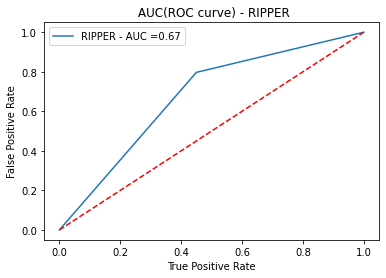

In [21]:
plot_roc_curve(y_test_enc, y_predicted, 'RIPPER')

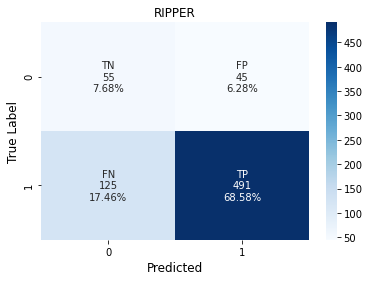

In [22]:
cf_matrix = confusion_matrix(y_test_enc, y_predicted)
make_confusion_matrix(cf_matrix, 'RIPPER')

# IREP

In [24]:
for pr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
        irep_clf = lw.IREP(random_state=42, prune_size=pr)
        irep_clf.fit(X_train, y_train, class_feat='genre_top', pos_class='Electronic')
        y_predicted = irep_clf.predict(X_test)
        print("\nprune_size: ", pr)
        print(classification_report(y_test_enc, y_predicted))


prune_size:  0.1
              precision    recall  f1-score   support

       False       0.36      0.54      0.43       100
        True       0.92      0.84      0.88       616

    accuracy                           0.80       716
   macro avg       0.64      0.69      0.66       716
weighted avg       0.84      0.80      0.82       716


prune_size:  0.2
              precision    recall  f1-score   support

       False       0.36      0.48      0.41       100
        True       0.91      0.86      0.88       616

    accuracy                           0.81       716
   macro avg       0.63      0.67      0.65       716
weighted avg       0.83      0.81      0.82       716


prune_size:  0.3
              precision    recall  f1-score   support

       False       0.51      0.25      0.34       100
        True       0.89      0.96      0.92       616

    accuracy                           0.86       716
   macro avg       0.70      0.61      0.63       716
weighted avg       0

irep.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is universal. All predictions it makes with method .predict will be positive. It may be untrained or was trained on a dataset split lacking negative examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is universal. All predictions it makes with method .predict will be positive. It may be untrained or was trained on a dataset split lacking negative examples.

/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pr

In [26]:
irep_clf = lw.IREP(random_state=42, prune_size=0.1)
irep_clf.fit(X_train, y_train, class_feat='genre_top', pos_class='Electronic')

In [27]:
y_predicted = irep_clf.predict(X_test)

In [28]:
print(classification_report(y_test_enc, y_predicted))

              precision    recall  f1-score   support

       False       0.36      0.54      0.43       100
        True       0.92      0.84      0.88       616

    accuracy                           0.80       716
   macro avg       0.64      0.69      0.66       716
weighted avg       0.84      0.80      0.82       716



In [29]:
irep_clf.out_model()

[[bit_rate=160-192] V
[duration=418-900] V
[duration=328-418] V
[instrumentalness=0.93-0.95] V
[tempo=85.0-93.32] V
[energy=0.94-1.0] V
[instrumentalness=0.83-0.86] V
[speechiness=0.11-0.2] V
[speechiness=0.2-0.65] V
[speechiness=0.07-0.08] V
[speechiness=0.06-0.07] V
[speechiness=0.08-0.11] V
[speechiness=0.04-0.05]]


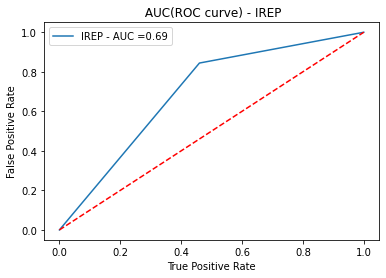

In [30]:
plot_roc_curve(y_test_enc, y_predicted, 'IREP')

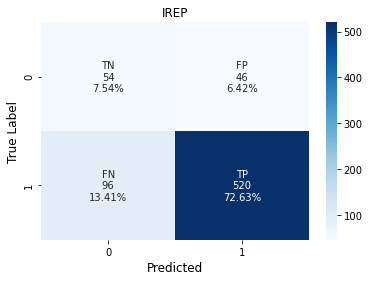

In [31]:
cf_matrix = confusion_matrix(y_test_enc, y_predicted)
make_confusion_matrix(cf_matrix, 'IREP')

# Electronic - Classical classifier

In [38]:
df = pd.read_csv('/Users/samuele/University/2.DM2/fma_metadata/echo_eleclass_noout.csv')
df.set_index('track_id', inplace=True)
display(df.head())
display(df.shape)
display(df['genre_top'].value_counts())

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,genre_top
track_id,,,,,,,,,,,
384,0.444822,0.561166,0.700912,0.817286,0.111111,0.036441,0.344763,91.077,249,256,Electronic
386,0.436375,0.585549,0.782927,0.894428,0.142187,0.047893,0.301543,130.464,357,256,Electronic
387,0.464508,0.493599,0.552749,0.736318,0.110117,0.055116,0.221480,136.255,326,256,Electronic
396,0.844582,0.144217,0.627557,0.868801,0.386048,0.091710,0.031676,94.035,1137,256,Electronic
397,0.625136,0.219944,0.167367,0.764413,0.349105,0.055938,0.093487,74.391,240,256,Electronic


(2266, 11)

Electronic    2058
Classical      208
Name: genre_top, dtype: int64

# Data Partitioning

In [43]:
attributes = [col for col in df.columns if col != 'genre_top']

X = df[attributes]
y = df['genre_top']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [44]:
# encoding labels
le = preprocessing.LabelEncoder()
y_test_enc = ~le.fit_transform(y_test).astype('bool')

In [46]:
df['genre_top'].value_counts()

Electronic    2058
Classical      208
Name: genre_top, dtype: int64

# RIPPER

In [47]:
for pr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
        clf = lw.RIPPER(random_state=42, prune_size=pr)
        clf.fit(X_train, y_train, pos_class='Classical')
        y_predicted = clf.predict(X_test)
        print("prune_size: ", pr)
        print(classification_report(y_test_enc, y_predicted))

prune_size:  0.1
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       618
        True       0.81      0.82      0.82        62

    accuracy                           0.97       680
   macro avg       0.90      0.90      0.90       680
weighted avg       0.97      0.97      0.97       680

prune_size:  0.2
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       618
        True       0.79      0.84      0.81        62

    accuracy                           0.96       680
   macro avg       0.89      0.91      0.90       680
weighted avg       0.97      0.96      0.97       680

prune_size:  0.3
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       618
        True       0.78      0.81      0.79        62

    accuracy                           0.96       680
   macro avg       0.88      0.89      0.89       680
weighted avg       0.96

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

In [48]:
clf = lw.RIPPER(random_state=42, prune_size=0.4)
clf.fit(X_train, y_train, pos_class='Classical')

In [50]:
y_predicted = clf.predict(X_test)
print(classification_report(y_test_enc, y_predicted))

              precision    recall  f1-score   support

       False       0.99      0.98      0.98       618
        True       0.82      0.89      0.85        62

    accuracy                           0.97       680
   macro avg       0.90      0.93      0.92       680
weighted avg       0.97      0.97      0.97       680



In [51]:
clf.out_model()

[[acousticness=0.99-1.0 ^ energy=0.0-0.09] V
[acousticness=0.99-1.0 ^ energy=0.09-0.28] V
[acousticness=0.89-0.99 ^ energy=0.0-0.09 ^ duration=118-155] V
[acousticness=0.89-0.99 ^ energy=0.0-0.09] V
[acousticness=0.89-0.99 ^ danceability=0.26-0.37 ^ tempo=150.06-173.93] V
[danceability=0.06-0.26 ^ liveness=0.34-0.94 ^ tempo=100.01-111.99] V
[acousticness=0.89-0.99 ^ danceability=0.37-0.45 ^ tempo=82.56-90.28] V
[acousticness=0.89-0.99 ^ duration=303-348 ^ danceability=0.06-0.26] V
[acousticness=0.99-1.0 ^ danceability=0.37-0.45]]


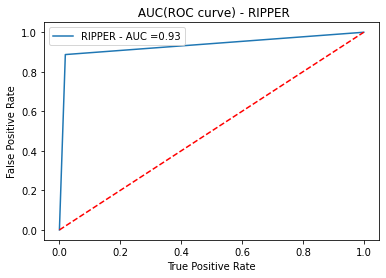

In [52]:
plot_roc_curve(y_test_enc, y_predicted, 'RIPPER')

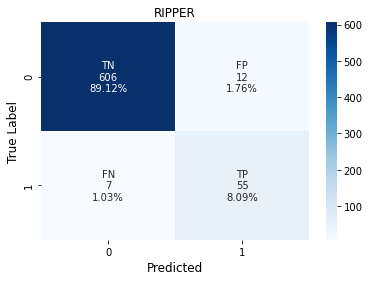

In [53]:
cf_matrix = confusion_matrix(y_test_enc, y_predicted)
make_confusion_matrix(cf_matrix, 'RIPPER')

# IREP

In [54]:
for pr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
        irep_clf = lw.IREP(random_state=42, prune_size=pr)
        clf.fit(X_train, y_train, pos_class='Classical')
        irep_clf.fit(X_train, y_train, class_feat='genre_top', pos_class='Classical')
        y_predicted = irep_clf.predict(X_test)
        print("\nprune_size: ", pr)
        print(classification_report(y_test_enc, y_predicted))


prune_size:  0.1
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       618
        True       0.81      0.77      0.79        62

    accuracy                           0.96       680
   macro avg       0.90      0.88      0.89       680
weighted avg       0.96      0.96      0.96       680


prune_size:  0.2
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       618
        True       0.81      0.77      0.79        62

    accuracy                           0.96       680
   macro avg       0.90      0.88      0.89       680
weighted avg       0.96      0.96      0.96       680


prune_size:  0.3
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       618
        True       0.79      0.87      0.83        62

    accuracy                           0.97       680
   macro avg       0.89      0.92      0.91       680
weighted avg       0

irep.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samuele/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted 

In [55]:
irep_clf = lw.IREP(random_state=42, prune_size=0.3)
irep_clf.fit(X_train, y_train, class_feat='genre_top', pos_class='Classical')

In [57]:
y_predicted = irep_clf.predict(X_test)

In [58]:
print(classification_report(y_test_enc, y_predicted))

              precision    recall  f1-score   support

       False       0.99      0.98      0.98       618
        True       0.79      0.87      0.83        62

    accuracy                           0.97       680
   macro avg       0.89      0.92      0.91       680
weighted avg       0.97      0.97      0.97       680



In [59]:
irep_clf.out_model()

[[acousticness=0.99-1.0] V
[acousticness=0.89-0.99 ^ energy=0.0-0.09]]


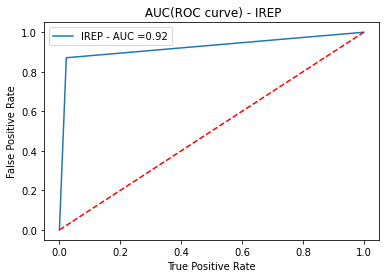

In [60]:
plot_roc_curve(y_test_enc, y_predicted, 'IREP')

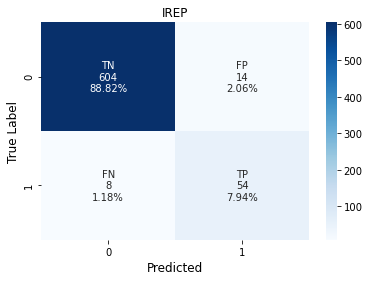

In [61]:
cf_matrix = confusion_matrix(y_test_enc, y_predicted)
make_confusion_matrix(cf_matrix, 'IREP')

In [63]:
y_predicted = irep_clf.predict(X_train)
print(classification_report(y_train, y_predicted))

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=['Classical' 'Electronic'] and y_pred=[False  True]. Make sure that the predictions provided by the classifier coincides with the true labels.